In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy.stats import norm 

In [34]:
def regenerate_fig_2b():
    V = np.arange(-80, -50, 1)
    V_rest = -70.0*np.ones((len(V)),)
    k = 0.3
    n = 2.0
    #R = 10*k*np.maximum(0.0,(V-V_rest))                       #linear
    #R = k*np.power(np.maximum(0.0, np.floor(V-V_rest)), n) #supralinear
    R = 70*(1/(1+np.exp(-V+V_rest+10)))                        #sublinear/sigmoid
    
    ax = plt.subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title('single-neuron I/O function (Figure 2, B)', fontsize=12)
    plt.xlabel(' Vm [mV]', fontsize=12)
    plt.ylabel('rate [Hz]', fontsize=12)
    plt.plot(V, R)

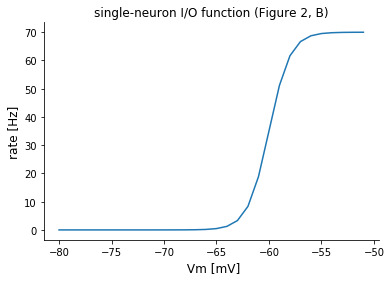

In [35]:
regenerate_fig_2b()

In [36]:
def generate_Weiner_process(m, n_steps, dt, scale=0.1):
    """
    Generate m Weiner process 
    """
    r = norm.rvs(size=(m, n_steps), scale = scale)
    out = np.cumsum(r, axis=-1)
    return out

In [37]:
V_rest = -70.0 # mV, resting membrane potential

tau_E = 20.0 # ms, E neuron time constant 
tau_I = 10.0 # ms, I neuron time constant 

W_EE = 1.25 # mV*s, connection weight 
W_IE = 1.2 # mV*s, connection weight
W_EI = 0.65 # mV*s, connection weight
W_II = 0.5 # mV*s, connection weight

b = 2.0 # mV, input baseline

sigma_0E = 0.2 # mV, noise standard deviation 
sigma_0I = 0.1 # mV, noise standard deviation 

tau_noise = 50.0 # ms, noise correlation time constant 

k = 0.3 # mV^-n*s^-1, nonlinearity gain 
n = 2 # nonlinearity exponent 

dt = 0.1 # time step

In [38]:
# checked Nov 21st

sigma_noise = np.zeros((2,2))
sigma_noise[0,0] = (np.power(sigma_0E,2))*(1+tau_E/tau_noise)
sigma_noise[1,1] = (np.power(sigma_0I,2))*(1+tau_I/tau_noise)

In [39]:
W = np.array([[W_EE, -W_EI],
            [W_IE, -W_II]])

In [40]:
tau = [tau_E, tau_I]

In [41]:
def generate_noise(n_step, 
                   N_E=1,
                   N_I=1,
                   scale=0.1,
                   tau_noise = tau_noise,
                   sigma_noise = sigma_noise):
    """
    Generate input noise for N units, each unit for n_steps
    """
    N = N_E+N_I
    # record 
    noise_list = np.empty((N, n_step))
    
    # initialize 
    noise = np.zeros((N,))
    
    r = norm.rvs(size=(N, n_step), scale = scale)
    
    # pregenerate Weiner process 
    #Weiner = generate_Weiner_process(N, n_step, dt, scale=scale)
    
    sigma_noise_multi = np.concatenate((sigma_noise[0,0]*np.ones((N_E,1)), sigma_noise[1,1]*np.ones((N_I,1))), axis=None)
    sigma_noise = np.diag(sigma_noise_multi)
    
    for i_step in range(n_step):
        
        # update noise 
        # checked Nov 20th 
        d_noise = (-noise*dt + (np.sqrt(2*tau_noise*sigma_noise)).dot(r[:,i_step]))/tau_noise
        noise = noise + d_noise
        noise_list[:,i_step] = noise
        
    return noise_list

In [52]:
def simulate(N_E=1,
             N_I=1,
             V_rest = V_rest, 
             n_step = 10000, # default simulate for 1s
             start_step = 0,
             dt = 0.1, 
             h = b, 
             W = W, 
             k = k, 
             n = n,
             tau = tau,
             noise_scale=1.0,
             h_scale=0,
             V_init = None):
    """
    V_rest: resting potential 
    N: total number of neurons 
    n_step: total simulation steps 
    dt: simulation time step 
    h: constant input 
    W: exc and inh weights
    k,n: parameter for r supralinear function
    tau: list of tau for corresponding units 
    """
    
    # Initialization
    N = N_E+N_I
    tau = np.concatenate((tau_E*np.ones((N_E,1)), tau_I*np.ones((N_I,1))), axis=None)
    
    if V_init is None: 
        V = V_rest * np.ones((N,)) # start at resting potential 
    else: 
        V = V_init
    V_rest_vec = V_rest*np.ones((N,))
    # pre-calculate input strenght noise
    h = np.random.normal(h,h_scale,n_step)
    #H = h*np.ones((N,))
    noise = np.zeros((N,))
    
    # record 
    record_step = n_step - start_step
    V_list = np.empty((N, record_step))
    noise_record_list = np.empty((N, record_step))
    r_list = np.empty((N, record_step))
    H_list = np.empty((N, record_step))
    
    # pre-generate noise 
    noise_list = generate_noise(n_step,N_E, N_I, scale=noise_scale)
    
    
    for i_step in range(n_step):
        # change input strength
        H = h[i_step]*np.ones((N,))
        # get noise 
        noise = noise_list[:,i_step]
        
        # get R 
        # checked Nov 20th 
        #R = 10*k*np.maximum(0.0,(V-V_rest))                       #linear
        R = k*np.power(np.maximum(0.0, np.floor(V-V_rest)), n) #supralinear
        #R = 70*(1/(1+np.exp(-V+V_rest+10)))                        #sublinear/sigmoid


        
        # update membrane potential 
        dv = np.divide(dt*(-V + V_rest_vec + H + noise + W.dot(R)), tau)
        # dv = np.divide(dt*(-V + V_rest_vec + H + noise), tau) # verified for the case of feedforward, Nov 21st
        # dv = np.divide(dt*(-V + V_rest_vec + H + W.dot(R)), tau) # verified for the case of no noise, Nov 21st 
        V = V + dv 
        
        # record 
        if i_step >= start_step: 
            r_list[:,i_step-start_step] = R
            V_list[:,i_step-start_step] = V
            noise_record_list[:,i_step-start_step] = noise
            H_list[:,i_step-start_step] = H
        
    V_last = V
        
    return V_list, r_list, noise_record_list, H_list, V_last

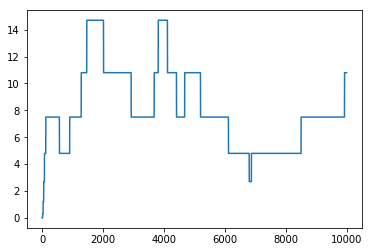

In [54]:
[V_list, r_list, noise_list, H_list, V_last] = simulate(N_E=1, N_I=1, n_step=10000, h=15,
                                                        noise_scale=1, h_scale=0,start_step=0)
plt.plot(r_list[0,:])

Text(0.5,0,'input h [mV]')

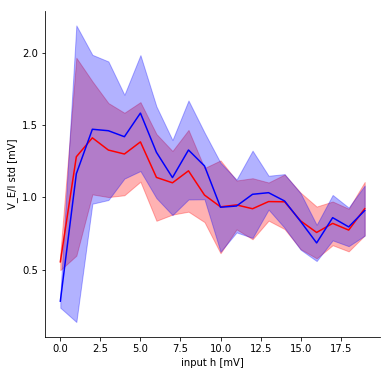

In [46]:
####NEW THING 12/3####
# initialize variables
N_E = 1        #number excitatory
N_I = 1        #number inhibitory
h = 10           #starting input strength
noise_scale = 1  #std of cells
h_scale = 1      #std of h
n_step = 10000   #number of timesteps; 10000=1sec

W_multi=W
#W_multi=get_connectivity(N_E,N_I)

V_var = np.empty([20,2])
V_var_std = np.empty([20,2])
for h in range(20):
    V_last_list = np.empty([10,2])
    for trial in range(10):
        [V_list, r_list, noise_list, H_list, V_last] = simulate(N_E=N_E, N_I=N_I, n_step=n_step, h=h, W=W_multi,
                                                        noise_scale=noise_scale, h_scale=h_scale,start_step=2000)
        exc = V_list[:N_E]
        inh = V_list[N_E:]
        V_last_list[trial] = [np.std(exc),np.std(inh)]
    V_var[h] = np.mean(V_last_list,axis=0)
    V_var_std[h] = np.std(V_last_list,axis=0)

f, (ax3) = plt.subplots(1, 1, figsize=(6,6))
plot_figure_2d_subplot(ax=ax3,
                       data_list=V_var, 
                       error_list=V_var_std,
                       ylabel='V_E/I std [mV]')
plt.xlabel('input h [mV]')
#plt.plot(np.arange(20),V_var[:,0],color='red')
#plt.plot(np.arange(20),V_var[:,1],color='blue')

#exc = V_list[:N_E]
#inh = V_list[N_E:]

#plot voltage traces
#plt.plot(np.arange(n_step),np.mean(exc,axis=0),color='red')
#plt.plot(np.arange(n_step),np.mean(inh,axis=0),color='blue')

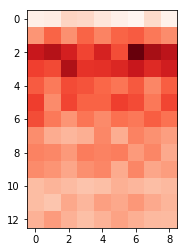

In [55]:
####NEW THING 12/4####
# initialize variables
N_E = 1        #number excitatory
N_I = 1        #number inhibitory
h = 10           #starting input strength
noise_scale = 1  #std of cells
h_scale = 0      #std of h
n_step = 10000   #number of timesteps; 10000=1sec

W_multi=W
#W_multi=get_connectivity(N_E,N_I)

trials = 10
num_h = [0,1,2,3,4,5,6,7,8,9,10,11,12]
num_sigmah = [0,0.25,0.5,0.75,1,1.25,1.5,1.75,2]
mean_V = np.empty([trials,len(num_h),len(num_sigmah)])
for trial in range(trials):
    for h in num_h:
        for h_scale in num_sigmah:
            [V_list, r_list, noise_list, H_list, V_last] = simulate(N_E=N_E, N_I=N_I, n_step=n_step, h=h, W=W_multi,
                                                                noise_scale=noise_scale, h_scale=h_scale,start_step=2000)

            exc = V_list[:N_E]
            inh = V_list[N_E:]
        
            mean_V[trial,num_h.index(h),num_sigmah.index(h_scale)] = np.std(exc)

var_V = np.mean(mean_V,axis=0)
plt.imshow(var_V, cmap='Reds', interpolation='nearest')
plt.show()

#plot voltage traces
#plt.plot(np.arange(n_step),np.mean(exc,axis=0),color='red')
#plt.plot(np.arange(n_step),np.mean(inh,axis=0),color='blue')

In [ ]:
  #######################################################################
  ##           CELLS AFTER THIS ARE FOR RECREATING FIGURE 2            ##
  ##     I MIGHT HAVE MESSED STUFF UP IN THERE SO DON'T RELY ON IT     ##
  ##                                                                   ##
  ## NEXT STEP IS PROBABLY DOING MULTIPLE TRIALS AND PLOTTING VARIANCE ##
  ##     AS WELL AS PLOTTING CONFIDENCE INTERVALS FOR FIGURE ABOVE     ##
  #######################################################################

In [26]:
def regenerate_figure_2c():
    
    H_total_list = np.empty((2, 100000))
    V_total_list = np.empty((2, 100000))
    
    for i in range(10):
        
        if i==0: 
            [V_list, r_list, noise_list, H_list, V_last]  = simulate(h=0.0)
        elif i ==1: 
            [V_list, r_list, noise_list, H_list, V_last]  = simulate(h=0.0, V_init = V_last)
        elif i<6:
            [V_list, r_list, noise_list, H_list, V_last]  = simulate(h=2.0, V_init = V_last)
        else:
            [V_list, r_list, noise_list, H_list, V_last]  = simulate(h=15.0, V_init = V_last)
        
        # record 
        H_total_list[:,i*10000:(i+1)*10000] = H_list 
        V_total_list[:,i*10000:(i+1)*10000] = V_list 
        
    T_list = np.arange(0,10,0.0001)
        
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,4))
    
    ax1.plot(T_list, V_total_list[0], label='exc', color='red')
    ax1.plot(T_list, V_total_list[1], label='inh', color='blue')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.set_ylabel(' V_E/I [mV]', fontsize=12)
    ax1.legend()

    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.plot(T_list, H_total_list[0])
    ax2.set_ylabel('h [mV]', fontsize=12)
    plt.xlabel('time (s)', fontsize=12)
    
    return H_total_list, V_total_list

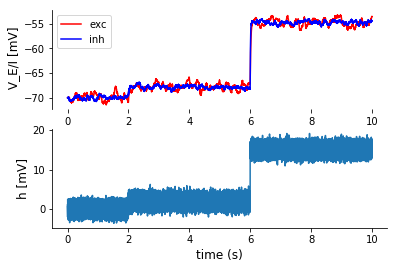

In [27]:
[H_total_list, V_total_list] = regenerate_figure_2c()

[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.3 0.3 0.3]]


(array([ 879.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0., 5753.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3368.]),
 array([0.   , 0.012, 0.024, 0.036, 0.048, 0.06 , 0.072, 0.084, 0.096,
        0.108, 0.12 , 0.132, 0.144, 0.156, 0.168, 0.18 , 0.192, 0.204,
        0.216, 0.228, 0.24 , 0.252, 0.264, 0.276, 0.288, 0.3

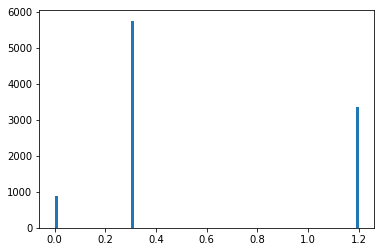

In [64]:
[V_list, r_list, noise_list, H_list, V_last]  = simulate(n_step=10000, h=2)
print(r_list)
plt.hist(r_list[0,:],100)


In [52]:
def simulate_figure_2d(h_max = 20,
                        n_trials = 5,
                        n_step = 20000,
                        start_step = 2000):
    """
    Regenerate figure 2D 
    
    Arguments 
    ---------
    n_trials: number of simulations to average over, 500 in the paper 
    """
    
    # get range of h to test
    h_range = np.arange(h_max+1)
    
    # record 
    V_std_list = np.empty((n_trials, h_max+1, 3))
    V_mean_list = np.empty((n_trials, h_max+1, 3))
    r_mean_list = np.empty((n_trials, h_max+1, 3))
    
    # simulate 
    for i_h, h in enumerate(h_range):
        
        for i_trial in range(n_trials):
            
            # simulate 
            [V_list, r_list, noise_list, H_list, V_last]  = simulate(n_step=n_step, 
                                                                     h=h, 
                                                                     W = np.array([[W_EE, -W_EI],[W_IE, -W_II]]),
                                                                     start_step=start_step) # allow for 2s to set to stable
            
            # record 
            V_std_list[i_trial][i_h][:2] = np.std(V_list, axis=1)
            V_mean_list[i_trial][i_h][:2] = np.mean(V_list, axis=1)
            r_mean_list[i_trial][i_h][:2] = np.mean(r_list, axis=1)
            
            # simulate for feedforward 
            [V_list, r_list, noise_list, H_list, V_last]  = simulate(n_step=n_step, 
                                                                     h=h, 
                                                                     W=np.zeros((2,2)),
                                                                     start_step=start_step)
            V_std_list[i_trial][i_h][2] = np.std(V_list[0])
            V_mean_list[i_trial][i_h][2] = np.mean(V_list[0])
            r_mean_list[i_trial][i_h][2] = np.mean(r_list[0])
            
            
            
    return V_std_list, V_mean_list, r_mean_list

In [32]:
def plot_figure_2d_subplot(ax, data_list, error_list, ylabel):
    h_range = np.arange(len(data_list))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    color_list = ['red', 'blue', 'gray']
    for i in range(data_list.shape[1]):
        ax.plot(h_range,data_list[:,i], color=color_list[i])
        ax.fill_between(h_range, 
                        data_list[:,i]-error_list[:,i],
                        data_list[:,i]+error_list[:,i],
                       alpha=0.3,
                       color=color_list[i])
    ax.set_ylabel(ylabel)

In [54]:
def regenerate_figure_2d(h_max=20,
                        n_trials=10):
    
    [V_std_list, V_mean_list, r_mean_list] = simulate_figure_2d(h_max=h_max, 
                                                                n_trials=n_trials)
    
    V_std_mean = np.mean(V_std_list, axis=0)
    V_mean_mean = np.mean(V_mean_list, axis=0)
    r_mean_mean = np.mean(r_mean_list, axis=0)

    V_std_std = np.std(V_std_list, axis=0)
    V_mean_std = np.std(V_mean_list, axis=0)
    r_mean_std = np.std(r_mean_list, axis=0)
    
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6,6))
    plot_figure_2d_subplot(ax=ax1,
                           data_list=r_mean_mean, 
                           error_list=r_mean_std,
                           ylabel='mean rate [Hz]')
    
    plot_figure_2d_subplot(ax=ax2,
                           data_list=V_mean_mean, 
                           error_list=V_mean_std,
                           ylabel='mean V_E/I [mV]')
    plot_figure_2d_subplot(ax=ax3,
                           data_list=V_std_mean, 
                           error_list=V_std_std,
                           ylabel='V_E/I std [mV]')
    plt.xlabel('input h [mV]')
    
    np.savez('figure_2d_data',
            V_std_list = V_std_list, 
            V_mean_list = V_mean_list,
            r_mean_list = r_mean_list)
    
    return r_mean_mean[:,0], r_mean_mean[:,1] #return only used for polyfit cell. unnecessary otherwise

In [55]:
regenerate_figure_2d()

KeyboardInterrupt: 

In [ ]:
##POLYFIT. SLOW. 12/3
[Freq_E,Freq_I] = regenerate_figure_2d()
plt.subplot(2,1,1)
plt.plot(Freq_E)
print(np.polyfit(np.arange(Freq_E.size),Freq_E,2))

plt.subplot(2,1,2)
plt.plot(Freq_I)
print(np.polyfit(np.arange(Freq_I.size),Freq_I,2))

